## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import wandb
import random
import os


current_dir = os.path.dirname(os.path.abspath(''))
two_up_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.append(two_up_dir)


from CenterSpeed.dataset.lidar_dataset import LidarDataset # weird steps for import needed for jupyter notebook

%env "WANDB_NOTEBOOK_NAME" "simple_model.ipynb"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


env: "WANDB_NOTEBOOK_NAME"="simple_model.ipynb"


wandb: Currently logged in as: nreichlin (f110-perception). Use `wandb login --relogin` to force relogin


True

## Load Data
This version works with raw lidar data, where the lidar scan is not preprocessed into images.

In [2]:
set = LidarDataset(dataset_path="../../dataset/data/combined_var_egoopp_big.csv")
set.add_data(csv_file="../../dataset/data/18_03_Dataset01.csv")
set.add_data(csv_file="../../dataset/data/18_03_Dataset01_07.csv")
set.use_heatmaps = False
#set.augment()
print("Loaded Dataset of size:", len(set))

Loaded Dataset of size: 4912


Infos

Lidar points: 		 1081
Lidar intensities: 	 1081
GT-Data: 		 5
Labels of the set: 	 ['lidar', 'intensities', 'x', 'y', 'vs', 'vd', 'yaw']
tensor([ 1.7272, -0.5297,  5.7488, -5.1437,  0.3555])
tensor(1260.)


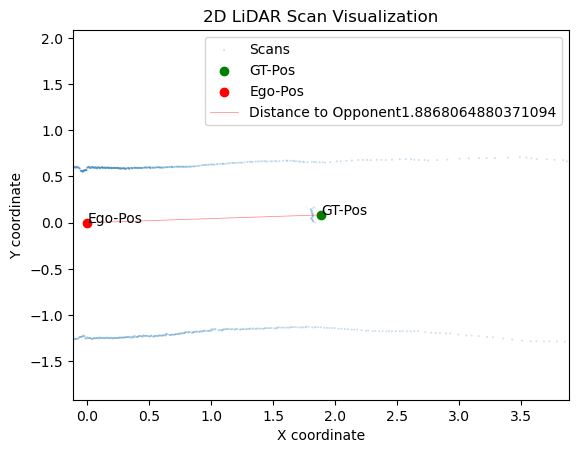

In [5]:
# set.preprocess()
# set.vis_preprocessed(10)
# set.heatmap()
# set.vis_heatmap(10)
lidar,intensities,data = set[0]
print("Lidar points: \t\t",len(lidar))
print("Lidar intensities: \t", len(intensities))
print("GT-Data: \t\t", len(data))
print("Labels of the set: \t", set.labels)
print(data)
print(intensities[-1])
set.vis(10)


## Define Model

In [4]:
class simple_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=80, stride=1)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=80, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(in_features= 1688, out_features= 20)
        self.fc2 = nn.Linear(in_features=20, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x= self.fc2(x)
        return x
    
class simple_model_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=4, kernel_size=100, stride=4)
        self.pool = nn.MaxPool1d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(in_features= 492, out_features= 20)
        self.fc2 = nn.Linear(in_features=20, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x= self.fc2(x)
        return x



## Definition of Parameters


In [5]:
import datetime

use_wandb = True
save_code = False
# Define the hyperparameters, logged in wandb
epochs = 100
learning_rate = 0.0001
architecture = "Simple Convolutional Neural Network V2"
dataset = "Lidar Dataset Egoopp Big, 18_03_Dataset01"
optimizer = "Adam"
batch_size = 32
time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
run_name = "Run_Simple_" + time

#wandb configurations
config = {
    "epochs": epochs,
    "learning_rate": learning_rate,
    "architecture": architecture,
    "dataset": dataset,
    "optimizer": optimizer
}
if use_wandb:
    #initialize wandb run
    run = wandb.init(project="simplest_model", config=config, name=run_name, save_code=save_code)#initialize wandb



train_size = int(len(set) * 0.7)  # 70% for training
val_size = int(len(set) * 0.15)  # 15% for validation
test_size = len(set) - (train_size + val_size)  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(set, [train_size, val_size, test_size])


training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle= False)

print("Size of Training Set: ", len(train_dataset))
print("Size of Testing Set: ", len(test_dataset))
print("Size of Validation Set: ", len(val_dataset))

#defining the model
#net = simple_model()
net = simple_model_v2()
#net.load_state_dict(torch.load("kajöflajkdf"))

optimizer = torch.optim.Adam(net.parameters(), lr= learning_rate)
print("Optimizer Initialized")

loss_fn = torch.nn.MSELoss()
print("Loss function initialized")




Size of Training Set:  1719
Size of Testing Set:  369
Size of Validation Set:  368
Optimizer Initialized
Loss function initialized


In [6]:
def train_epoch():
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        lidars, intensities, gts = data
        inputs = [torch.stack([lidar, intensity]).float() for lidar, intensity in zip(lidars, intensities)]
        inputs = torch.stack(inputs)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = net(inputs) 
        # Compute the loss and its gradients
        loss = loss_fn(outputs.float(), gts[:, :-1].float())
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        last_loss = running_loss # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        running_loss = 0.

    return last_loss

In [7]:
if use_wandb:
    assert wandb.run is not None, "No wandb run found!"

# Initializing in a separate cell so we can easily add more epochs to the same run
epoch_number = 0

EPOCHS = epochs

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    net.train(True)
    avg_loss = train_epoch()


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    net.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vlidars, vintensities, vgts = vdata
            vinputs = [torch.stack([lidar, intensity]).float() for lidar, intensity in zip(vlidars, vintensities)]
            vinputs = torch.stack(vinputs)

            voutputs = net(vinputs)
            vloss = loss_fn(voutputs.float(), vgts[:, :-1].float())
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    if wandb.run is not None:
        wandb.log({"train-loss": avg_loss, "validation-loss": avg_vloss})
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    epoch_number += 1

run.display()
wandb.finish()

EPOCH 1:
  batch 1 loss: 7818.9990234375
  batch 2 loss: 4120.4677734375
  batch 3 loss: 3605.3671875
  batch 4 loss: 2252.51611328125
  batch 5 loss: 1750.40478515625
  batch 6 loss: 1323.03076171875
  batch 7 loss: 923.1678466796875
  batch 8 loss: 1050.16357421875
  batch 9 loss: 850.99609375
  batch 10 loss: 793.7354736328125
  batch 11 loss: 1041.82958984375
  batch 12 loss: 837.6400146484375
  batch 13 loss: 952.5562744140625
  batch 14 loss: 894.3411254882812
  batch 15 loss: 594.7203369140625
  batch 16 loss: 547.4868774414062
  batch 17 loss: 504.3846130371094
  batch 18 loss: 783.9882202148438
  batch 19 loss: 679.3860473632812
  batch 20 loss: 631.7598266601562
  batch 21 loss: 608.9055786132812
  batch 22 loss: 557.8838500976562
  batch 23 loss: 633.1212158203125
  batch 24 loss: 505.915771484375
  batch 25 loss: 567.7799072265625
  batch 26 loss: 329.8960876464844
  batch 27 loss: 569.7453002929688
  batch 28 loss: 437.8402099609375
  batch 29 loss: 492.6699523925781
  bat

/home/f1tenth/anaconda3/envs/per-ml/lib/python3.12/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train-loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation-loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train-loss,1.54244
validation-loss,1.86588


## Save Model


In [17]:


# Save the model
torch.save(net.state_dict(), "models/"+run_name +"augmented"+ ".pt")

## Testing

Test Sample:  598  Output:  [ 1.5655862 -0.2569673]


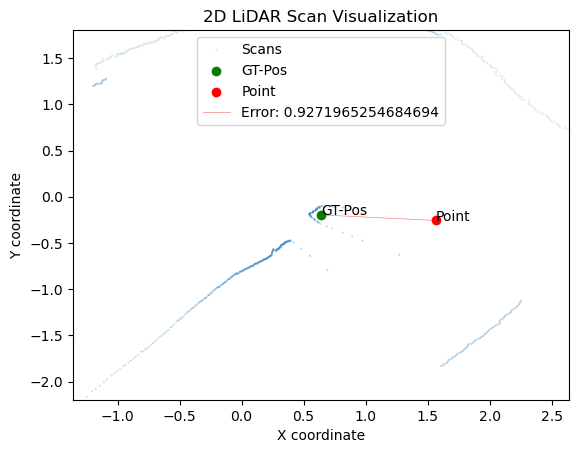

Test Sample:  266  Output:  [ 1.2899747  -0.44845933]


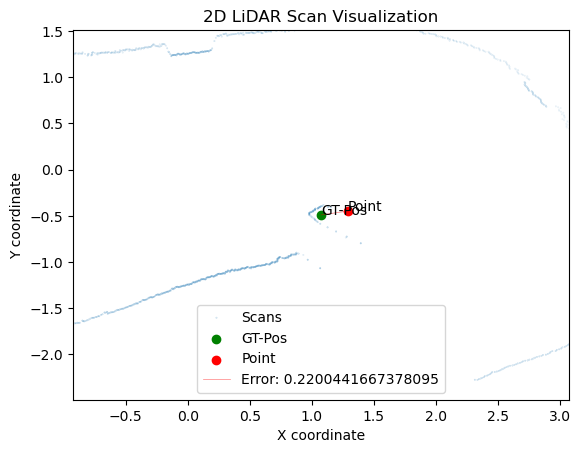

Test Sample:  631  Output:  [ 1.3025603 -0.3358297]


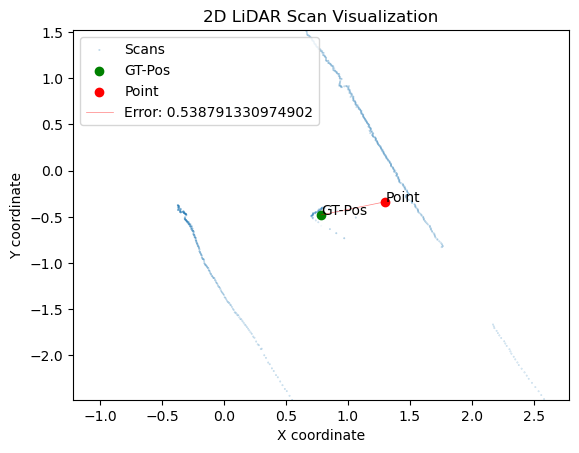

Test Sample:  467  Output:  [ 1.25636    -0.10306221]


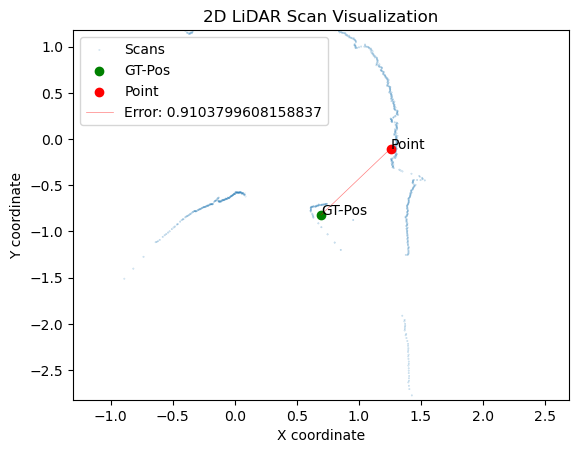

Test Sample:  838  Output:  [ 1.4214052 -0.2652781]


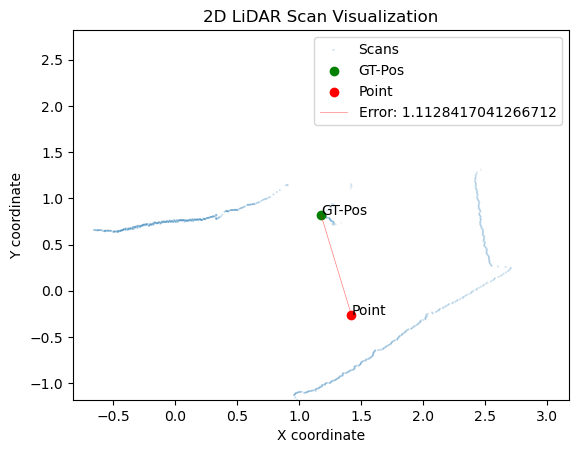

Train Sample:  957  Output:  [ 1.25636    -0.10306221]


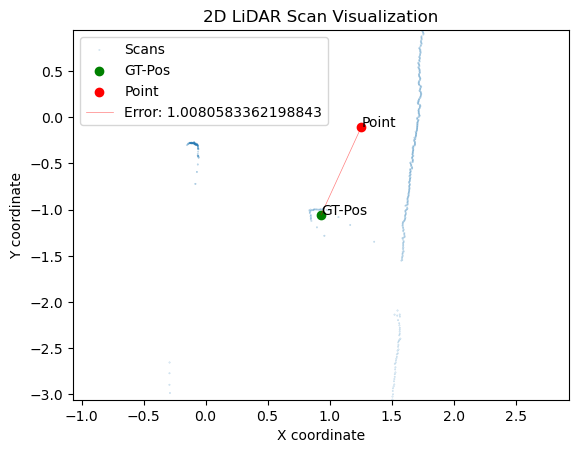

Train Sample:  505  Output:  [0.8813976  0.78968054]


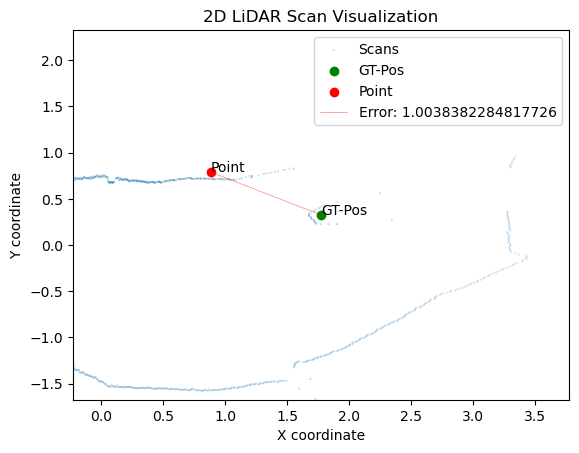

Train Sample:  122  Output:  [1.0878878  0.58751744]


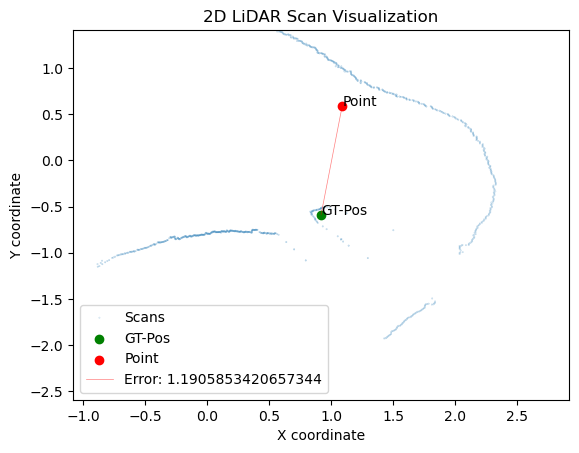

Train Sample:  688  Output:  [1.4920729  0.24127182]


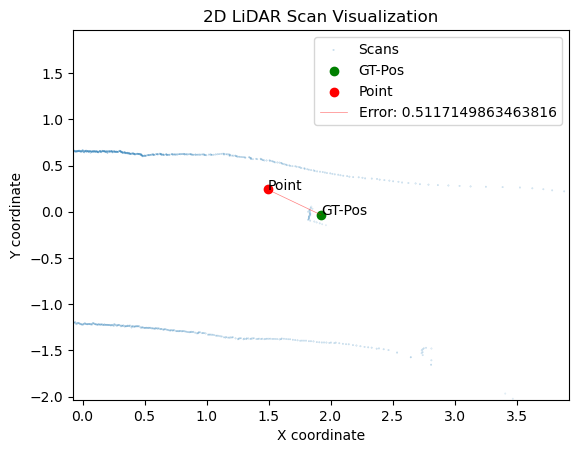

Train Sample:  418  Output:  [ 1.25636    -0.10306221]


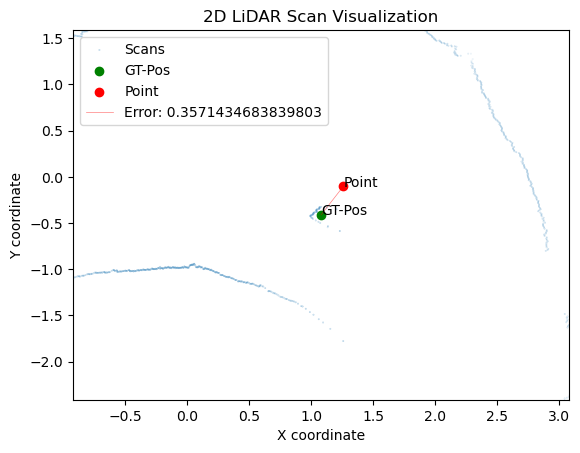

In [18]:
with torch.no_grad():
    net.eval()
    for index in [random.randint(0, len(test_dataset)) for _ in range(5)]:
        l, i, d = test_dataset[index]
        output = net(torch.stack([torch.stack([l, i]).float()])).detach().numpy()[0]
        print("Test Sample: ", index, " Output: ", output[0:2])
        set.vis(index, output[0:2])

    for index in [random.randint(0, len(test_dataset)) for _ in range(5)]:
        l, i, d = train_dataset[index]
        output = net(torch.stack([torch.stack([l, i]).float()])).detach().numpy()[0]
        print("Train Sample: ", index, " Output: ", output[0:2])
        set.vis(index, output[0:2])

    
    
        

In [20]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train-loss,█▅▅▃▅▂▄▃▂▂▂▃▁▂▁▁▃▂▁▂▂▂▂▂▁▃▁▁▂▁▁▁▂▁▂▂▁▃▁▁
validation-loss,█▅▄▂▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁
train-loss,0.23761
validation-loss,0.57532
